# Section 1.0 Preface & Disclaimer

From the get-go, we realized the importance of seasonality factoring into the analysis of this dataset, but in a more genreral/holistic view, it was due to the data being a time-series spanning two years, with entries (rows) between every hour.

Due to the recent release of NeuralProphet by joint collaboration from Stanford & Facebook (now Meta), solely targeted towards Time-Series Analysis, we have decided to leverage this model format to build our predictive analysis off of.

In [82]:
%pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to c:\users\sunny\appdata\local\temp\pip-req-build-u7qv_g3o
  Resolved https://github.com/ourownstory/neural_prophet.git to commit 0c8459528d4343c5a8b54d4120b22f089419e423
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for neuralprophet: filename=neuralprophet-0.3.3-py3-none-any.whl size=82316 sha256=f1dffb1c30238ba1fdc48edb52466472e848a33d3f0022119a2a8afe80cad3da
  Stored in directory: C:\Users\sunny\AppData\Local\Temp\pip-ephem-wheel-cache-uzcwkm2i\wheels\32\ce\37\d289cb9c67e62f7912fc3a25e624277ea47902c32e24371a78
Successfully built neuralprophet
  Attempting uninstall: neuralprophet
    Found existing installation: neuralprophet 0

  Running command git clone --filter=blob:none --quiet https://github.com/ourownstory/neural_prophet.git 'C:\Users\sunny\AppData\Local\Temp\pip-req-build-u7qv_g3o'
  Running command git submodule update --init --recursive -q


In [13]:
%pip install neuralprophet
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [77]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

# Section 1.0 Data Display & Description

Using the below predictors/descriptions we output the first `20` entries (rows) as well as basic descriptive statistics of the dataset.

The data is provided to you in NYU Brightspace. It contains 17414 records in total,
ranging from 2015-01-04 to 2017-01-03. In each record, we have the following columns:

* "timestamp" - timestamp field for grouping the data
* "cnt" - the count of new bike shares
* "t1" - real temperature in Celsius
* "t2" - "feels like" temperature in Celsius
* "hum" - humidity in percentage
* "windspeed" - wind speed in km/h
* "weathercode" - category of the weather (1-clear; 2-scattered clouds; 3-broken clouds; 4-
* "cloudy" - 7-light rain; 10-rain with thunderstorm; 26-snowfall; 94-freezing fog)
* "isholiday" – binary variable - 1 holiday / 0 non holiday
* "isweekend" - binary variable - 1 if the day is weekend / 0 non weekend
* "season" – category of the season (0-spring ; 1-summer; 2-fall; 3-winter)

In [75]:
df = pd.read_csv('bike_sharing_dataset.csv')

In [4]:
df.head(30)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [5]:
df.describe(include='all')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
unique,17414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,NaN,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,NaN,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,NaN,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,NaN,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seabor

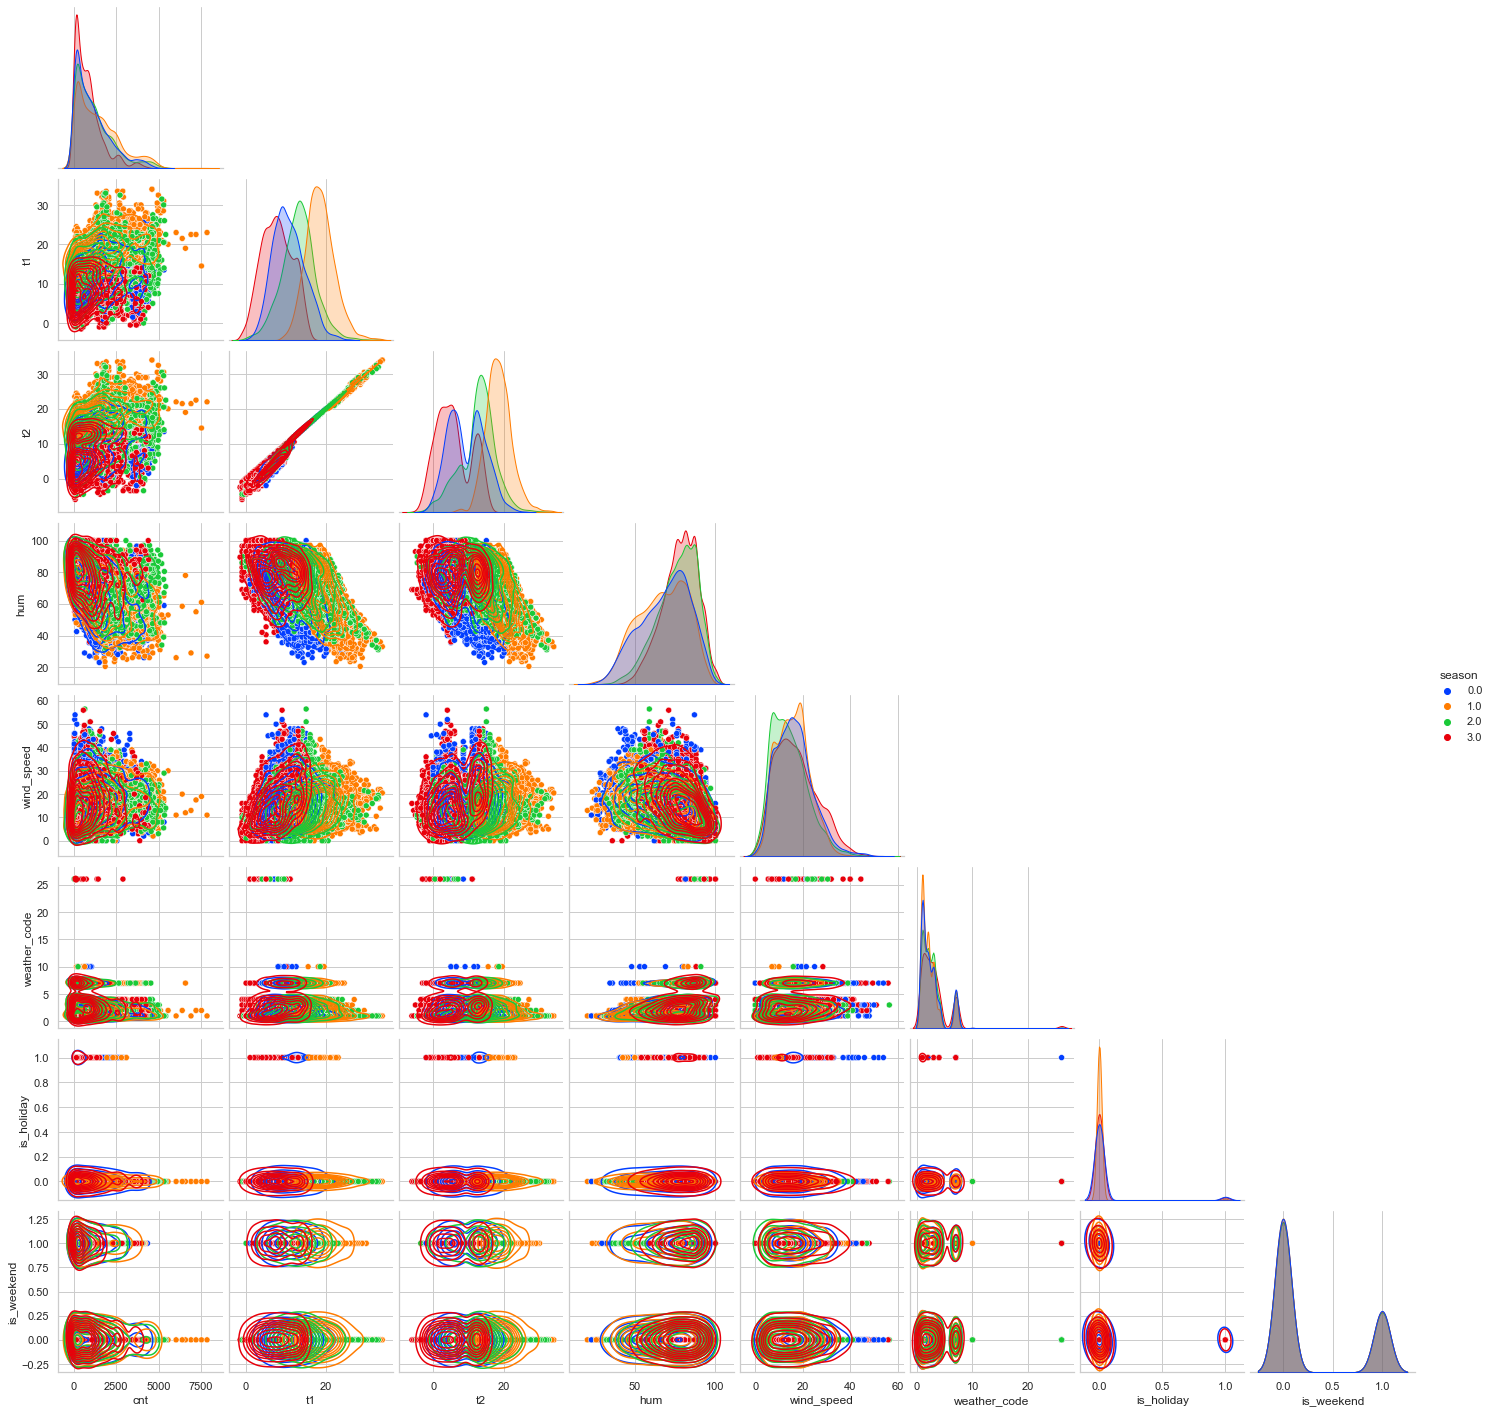

In [6]:
pairplt = sns.pairplot(data=df, hue='season', corner=True, palette='bright')
pairplt.map_lower(sns.kdeplot, levels=10, color=".2")

# Section 2.0 `NeuralProphet` Model Initialization & Fitting

In [109]:
df_NP = df.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]
df_NP = add_missing_dates_nan(df_NP, 'H')[0]

In [110]:
df_NP

,ds,y
0,2015-01-04 00:00:00,182.0
1,2015-01-04 01:00:00,138.0
2,2015-01-04 02:00:00,134.0
3,2015-01-04 03:00:00,72.0
4,2015-01-04 04:00:00,47.0
...,...,...
17539,2017-01-03 19:00:00,1042.0
17540,2017-01-03 20:00:00,541.0
17541,2017-01-03 21:00:00,337.0
17542,2017-01-03 22:00:00,224.0


In [111]:
df_NP.isnull().values.any()

True

In [112]:
df_NP = df_NP.assign(y=fill_linear_then_rolling_avg(df_NP['y'], limit_linear=10, rolling=50)[0])

In [113]:
df_NP.isnull().values.any()

False

In [115]:
df_NP[['y']] = MinMaxScaler().fit_transform(df_NP[['y']])

In [116]:
df_train = df_NP.loc[:15112,:]
df_test = df_NP.loc[15112:,:]

In [117]:
train = df_train.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]
test = df_test.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]

In [118]:
def plot_forecast(model, data, periods=0, historic_pred=True, highlight_steps_ahead=None, xlabel='Date', ylabel=None, title=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    fig, ax = plt.subplots(figsize=(14,10))

    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

    else:    
        model.plot(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")


In [119]:
def plot_validation(metrics_df, metrics = ['SmoothL1Loss', 'MAE', 'RMSE']):

    fig, axs = plt.subplots(ncols=len(metrics), nrows=1, sharex=True, sharey=True, figsize=(20, 8))
    fig.suptitle('Validation Metrics', fontsize=20, y=0.95)

    for metric, ax in zip(metrics, axs.ravel()):
        ax.plot(metrics_df[metric], 'ob', linewidth=6, label='Training Loss', markersize='3')
        ax.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='Validation Loss')

        ax.set_xlabel('Training Loss')
        ax.set_ylabel('Validation Loss')
        ax.set_title(metric)
        ax.legend()

## Section 2.1 - Model 1

In [120]:
model1 = NeuralProphet() ## Need to figure out n_lags

In [121]:
metrics1 = model1.fit(train, freq='H', validation_df=test)

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

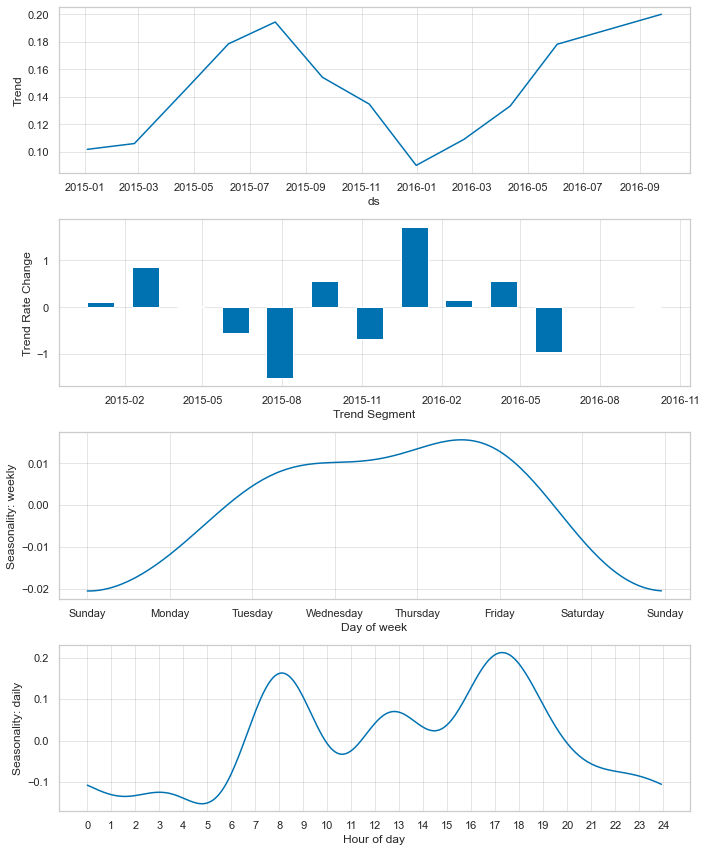

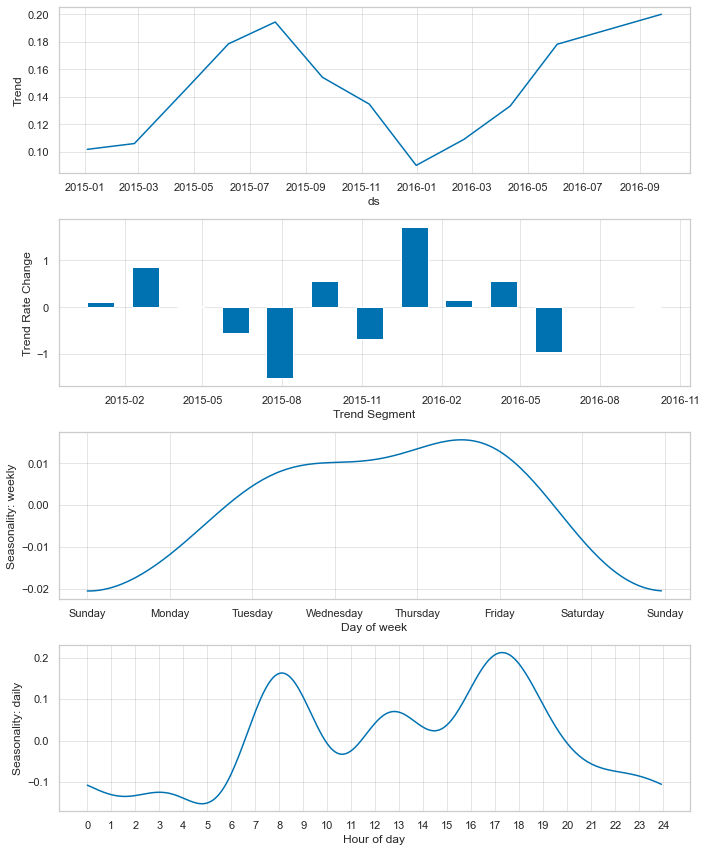

In [122]:
model1.plot_parameters()

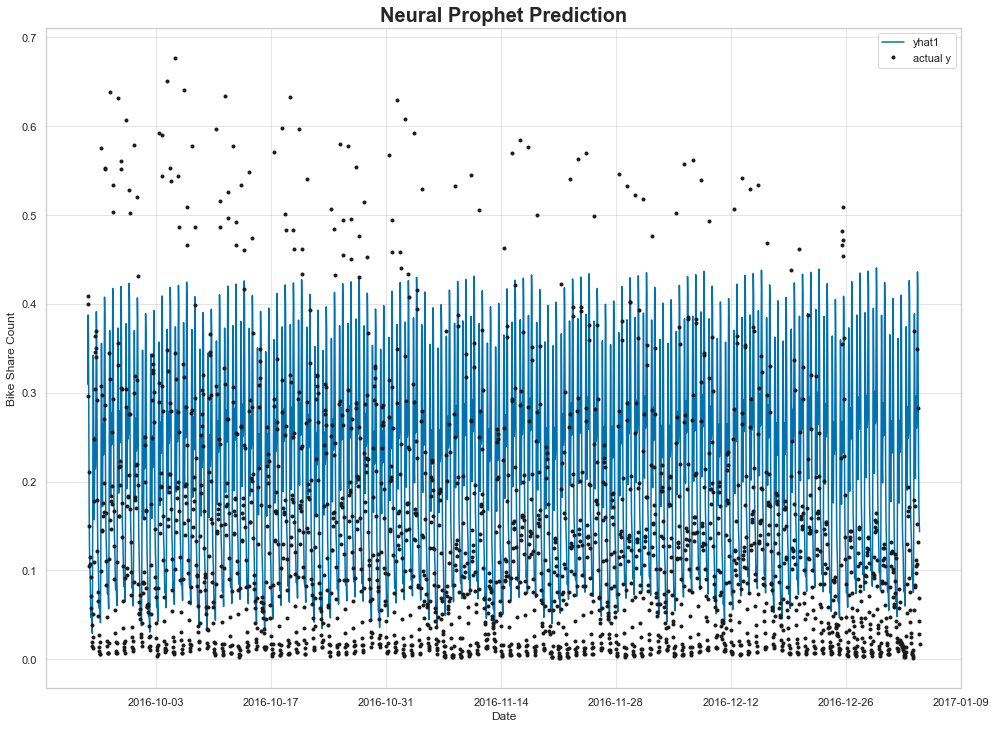

In [123]:
plot_forecast(model1, test, xlabel='Date', ylabel='Bike Share Count', title='Neural Prophet Prediction')

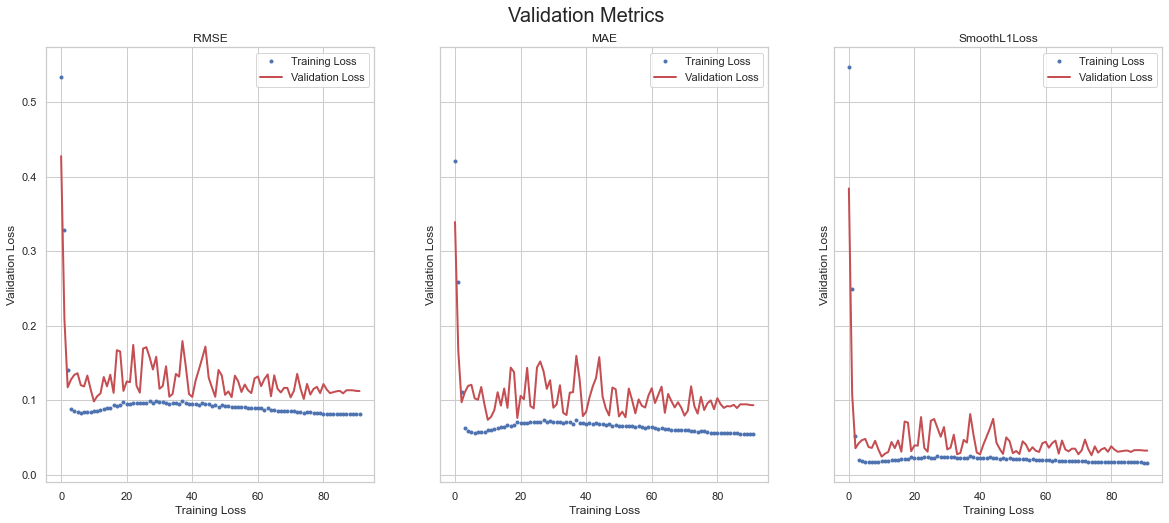

In [124]:
plot_validation(metrics1, metrics=['RMSE', 'MAE', 'SmoothL1Loss'])

In [125]:
metrics1

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.546776,0.420338,0.533924,0.0,0.384073,0.339075,0.427468
1,0.249604,0.258966,0.327920,0.0,0.107790,0.166596,0.209749
2,0.052096,0.110632,0.140767,0.0,0.035669,0.097317,0.117466
3,0.019789,0.062342,0.088905,0.0,0.042465,0.110804,0.127653
4,0.018343,0.058438,0.085584,0.0,0.046532,0.119367,0.134007
...,...,...,...,...,...,...,...
87,0.016627,0.055403,0.081433,0.0,0.033060,0.094637,0.113425
88,0.016585,0.055424,0.081351,0.0,0.033137,0.094517,0.113502
89,0.016554,0.055240,0.081348,0.0,0.033056,0.094588,0.113364
90,0.016524,0.055306,0.081098,0.0,0.032575,0.093645,0.112541


## Section 2.2 - Model 2

In [135]:
# Current model
model2 = NeuralProphet(
                        growth='linear',  # Determine trend types: 'linear', 'discontinuous', 'off'
                        changepoints=None, # list of dates that may include change points (None -> automatic )
                        n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
                        changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
                        trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
                        trend_reg_threshold=False, # Requires regularization for trend to be changed
                        yearly_seasonality='auto', # Automatically fits yearly seasonality
                        weekly_seasonality='auto', # Automatically fits weekly seasonality
                        daily_seasonality='auto', # Automatically fits daily seasonality
                        seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
                        seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
                        n_forecasts=1, # Set at default 1 for forecasting one step ahead
                        n_lags=24*7, # To include 7 days worth of AR lag
                        num_hidden_layers=8, # 8 hidden layers for the network
                        d_hidden=64, # Dimension of hidden layers of AR-Net
                        learning_rate=None, # Automatically determines learning rate
                        epochs=None, # Automatically sets the learning rate (based on data size)
                        loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
                        # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)

model2.add_country_holidays('USA') # Adds effects of US holidays
model2.add_seasonality(name='Seasons', period=365, fourier_order=1) # Adds seasonality component with first order fourier series for simple cyclical effects

In [136]:
metrics2 = model2.fit(train, freq='H', validation_df=test)

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

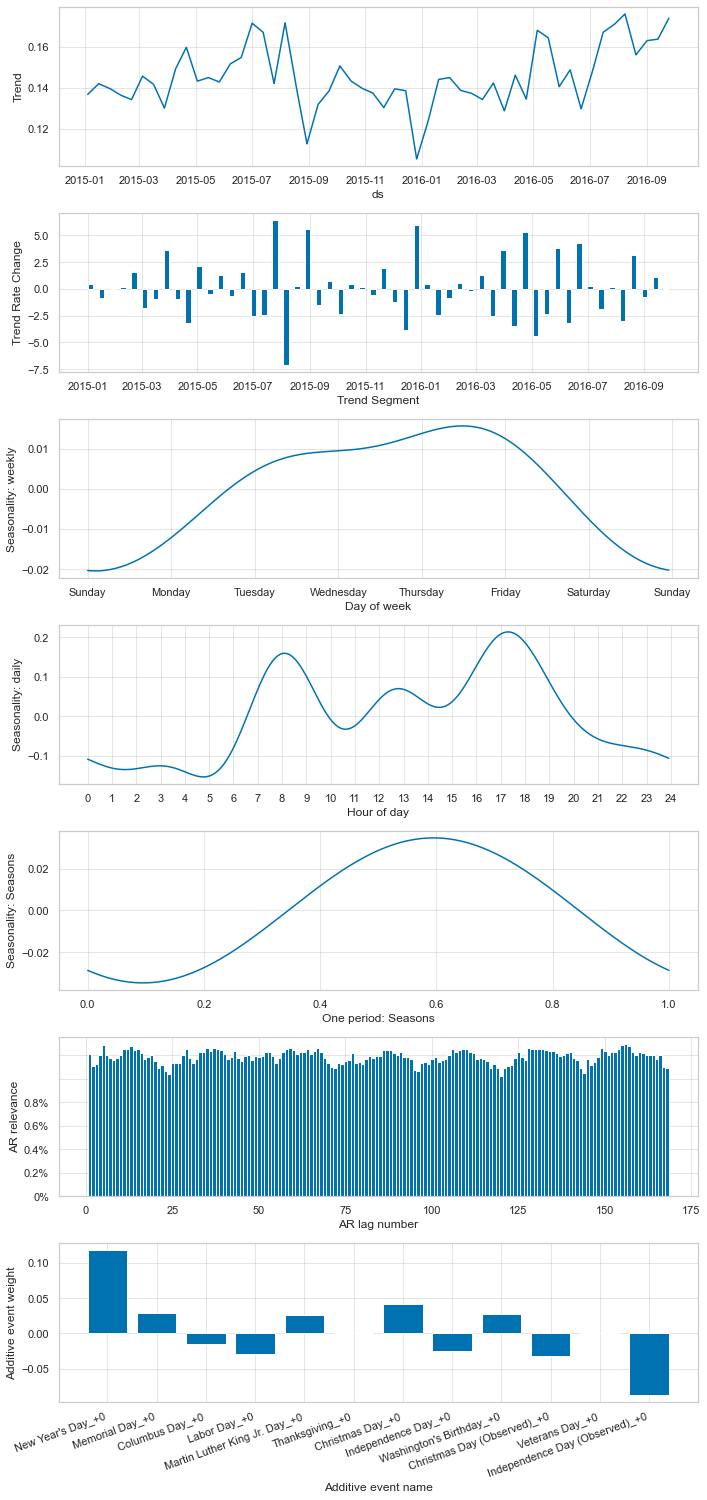

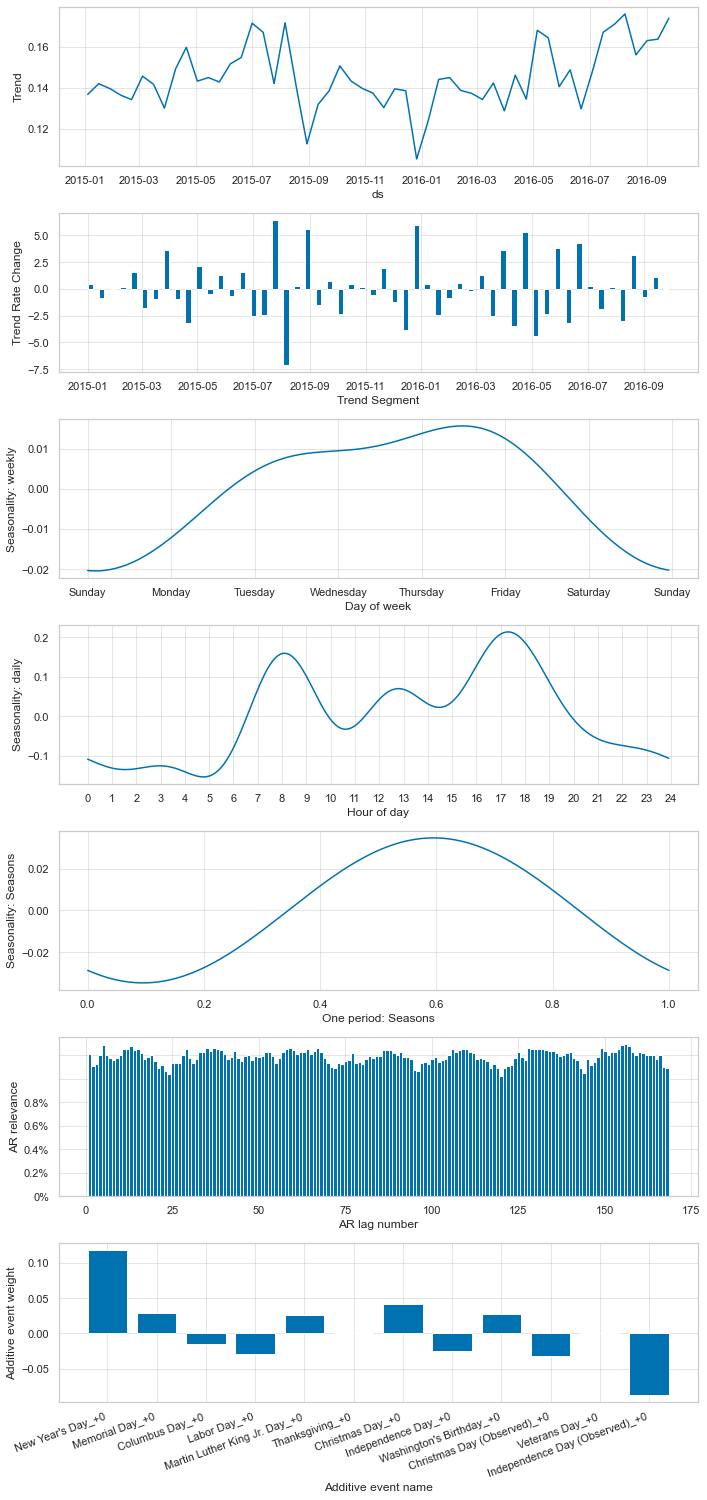

In [137]:
model2.plot_parameters()

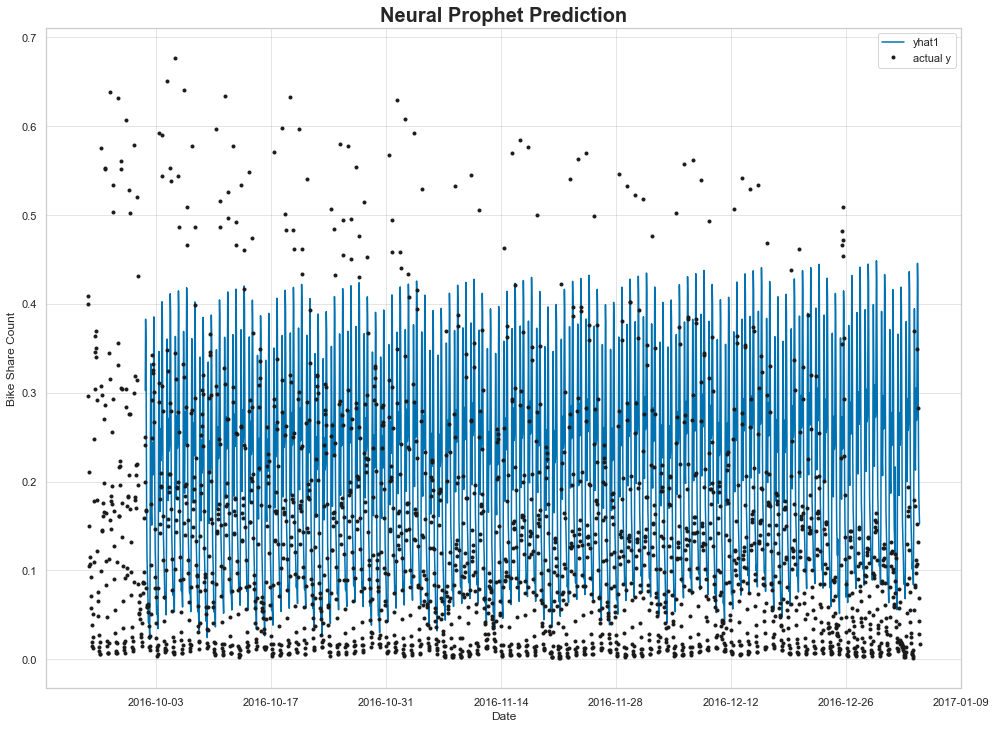

In [138]:
plot_forecast(model2, test, xlabel='Date', ylabel='Bike Share Count', title='Neural Prophet Prediction')

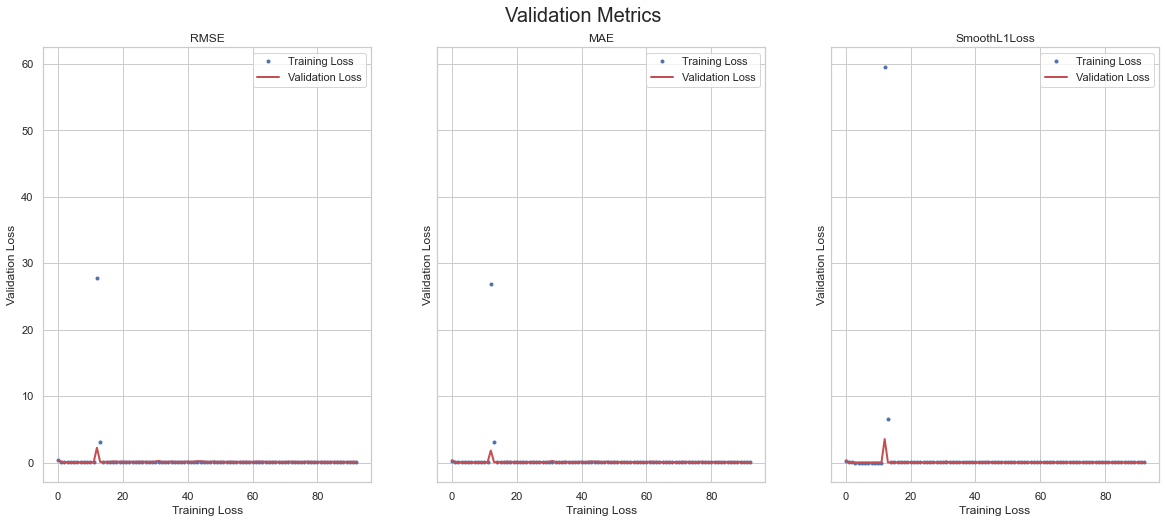

In [139]:
plot_validation(metrics2, metrics=['RMSE', 'MAE', 'SmoothL1Loss'])

In [140]:
metrics2

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.306960,0.291113,0.361851,0.0,0.306982,0.324386,0.355976
1,0.049465,0.106428,0.137278,0.0,0.043351,0.110841,0.130079
2,0.014052,0.055647,0.074257,0.0,0.011544,0.052706,0.065305
3,0.006358,0.035517,0.049017,0.0,0.011000,0.054520,0.066309
4,0.004994,0.032189,0.043765,0.0,0.003129,0.025684,0.035025
...,...,...,...,...,...,...,...
88,0.016467,0.055398,0.080909,0.0,0.032708,0.093781,0.112523
89,0.016394,0.055216,0.080815,0.0,0.033520,0.094313,0.113994
90,0.016309,0.055061,0.080651,0.0,0.032769,0.092939,0.112672
91,0.016276,0.054961,0.080546,0.0,0.033747,0.094725,0.114342


## Section 2.3 - Model 3

In [141]:
model3 = NeuralProphet(
    growth='linear',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality='auto', # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=12, ###!!! Hyperparameter tuning from model2 makes n_lags=5 work best
    num_hidden_layers=8, # 8 hidden layers for the network
    d_hidden=64, # Dimension of hidden layers of AR-Net
    learning_rate=None, # Automatically determines learning rate
    epochs=12, ###!!! Manual early stopping based on model2
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    impute_missing=True, ## Imputes missing data using linear approximation / if multiple missing, uses trendsetting
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None)
)

model3.add_country_holidays('USA') # Adds effects of US HOLIDAYS
model3.add_seasonality(name='Seasons', period=365, fourier_order=1) # Adds SEASONALITY component with first order fourier series for simple cyclical effects

In [142]:
metrics3 = model3.fit(train, freq='H', validation_df=test)

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

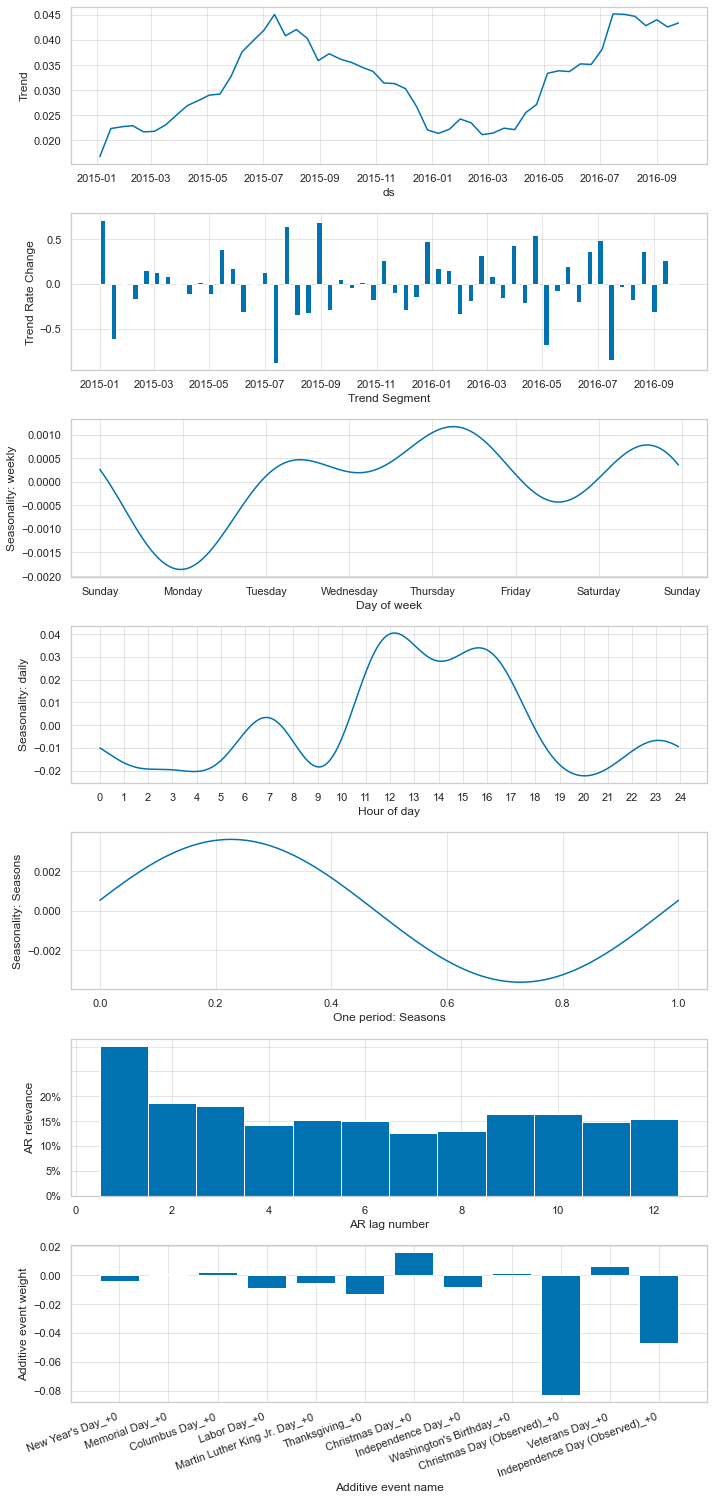

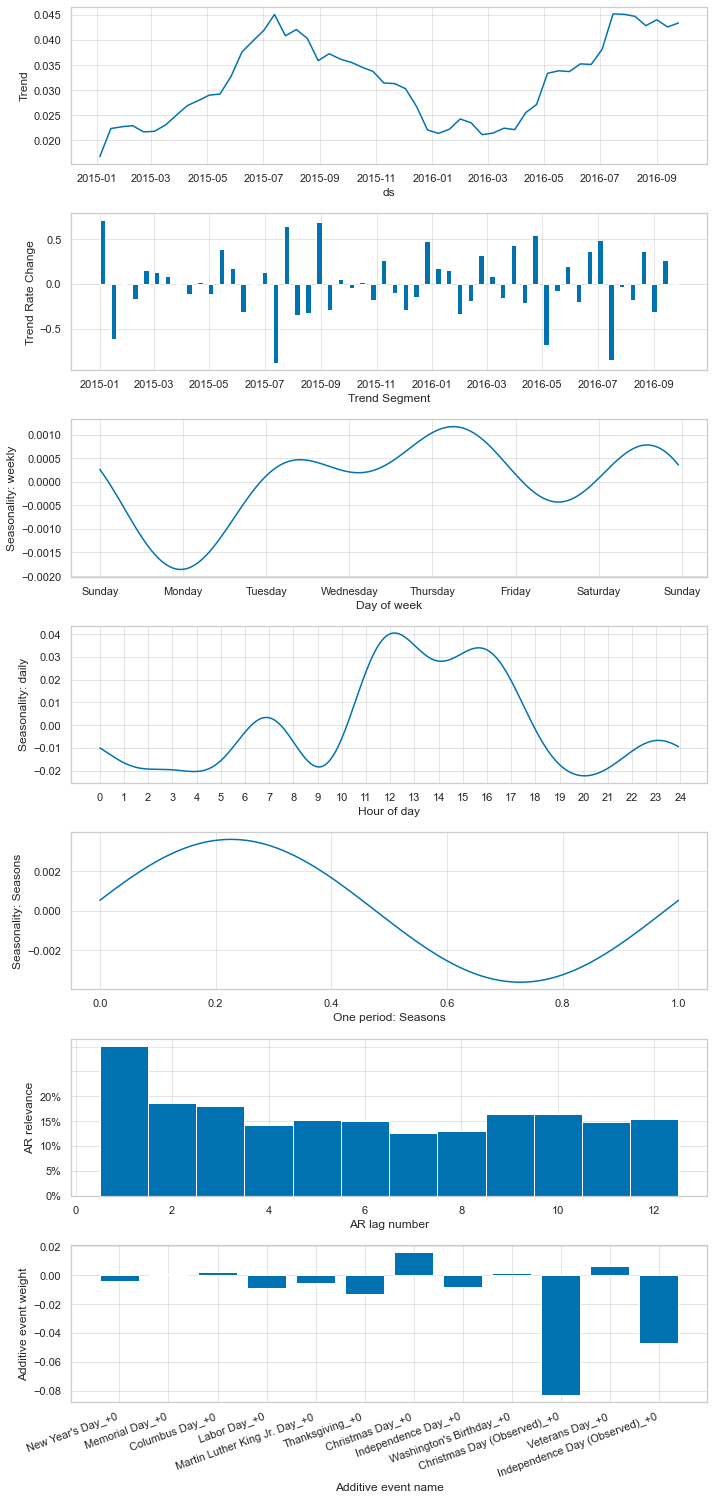

In [143]:
model3.plot_parameters()

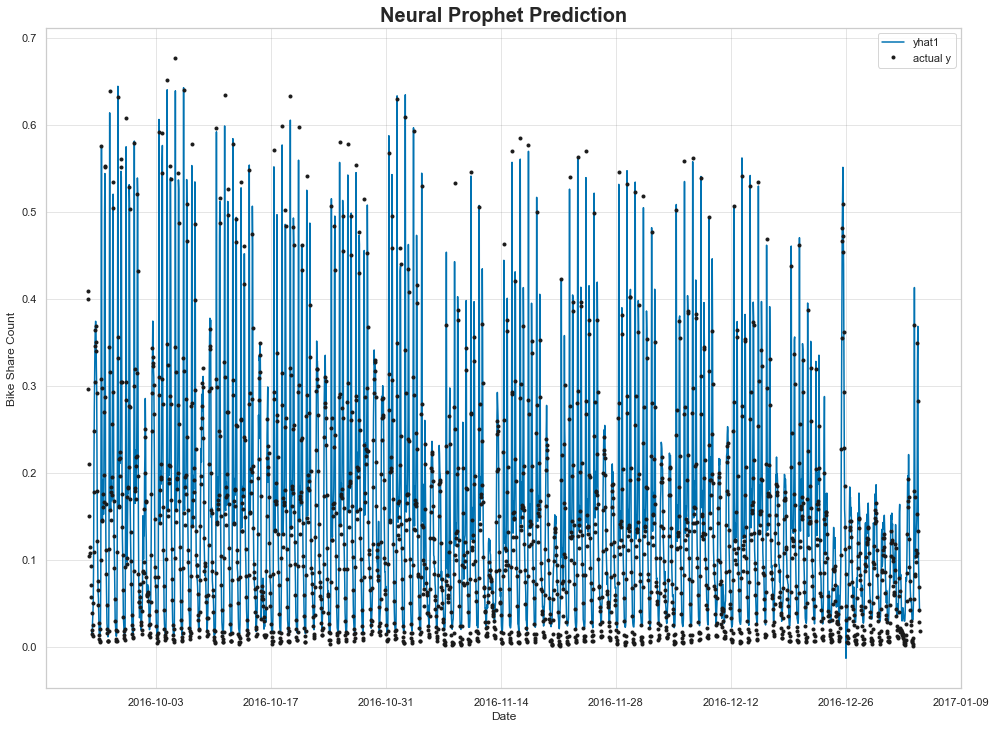

In [144]:
plot_forecast(model3, test, xlabel='Date', ylabel='Bike Share Count', title='Neural Prophet Prediction')

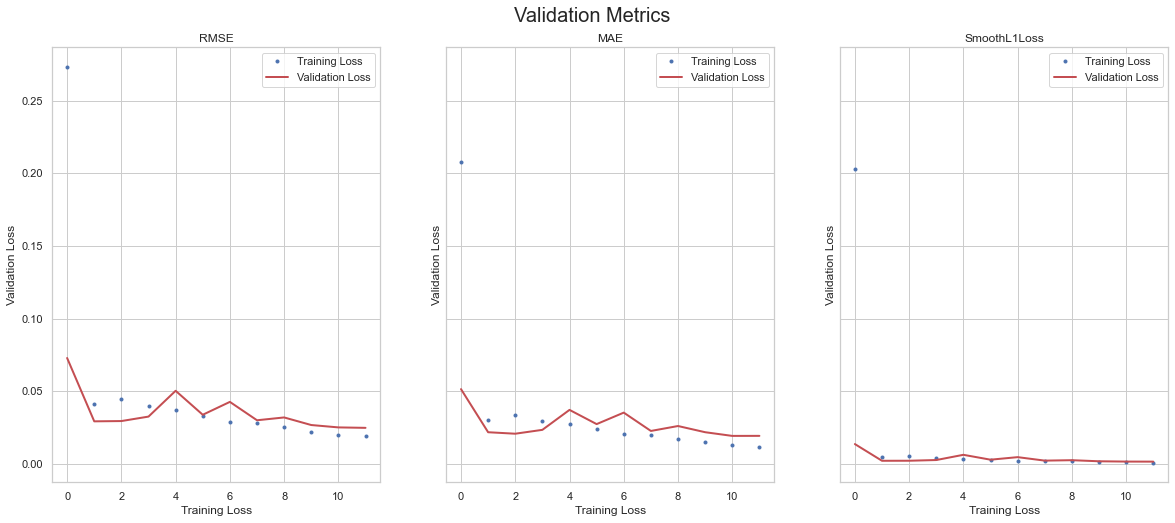

In [147]:
plot_validation(metrics3, metrics=['RMSE', 'MAE', 'SmoothL1Loss'])

In [148]:
metrics3

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.203148,0.207687,0.272972,0.0,0.013640,0.051446,0.072860
1,0.004501,0.030126,0.041384,0.0,0.002142,0.021790,0.029285
2,0.005589,0.033884,0.044796,0.0,0.002173,0.020771,0.029476
3,0.004139,0.029530,0.039592,0.0,0.002659,0.023430,0.032548
4,0.003595,0.027383,0.037381,0.0,0.006255,0.037164,0.050307
5,0.002854,0.023886,0.032618,0.0,0.002897,0.027383,0.033810
6,0.002161,0.020693,0.028890,0.0,0.004643,0.035282,0.042667
7,0.002031,0.019986,0.028042,0.0,0.002254,0.022670,0.030026
8,0.001677,0.017452,0.025357,0.0,0.002546,0.026063,0.031961
9,0.001253,0.014817,0.021954,0.0,0.001805,0.021804,0.026743


## Section 3.0 - Appendix

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



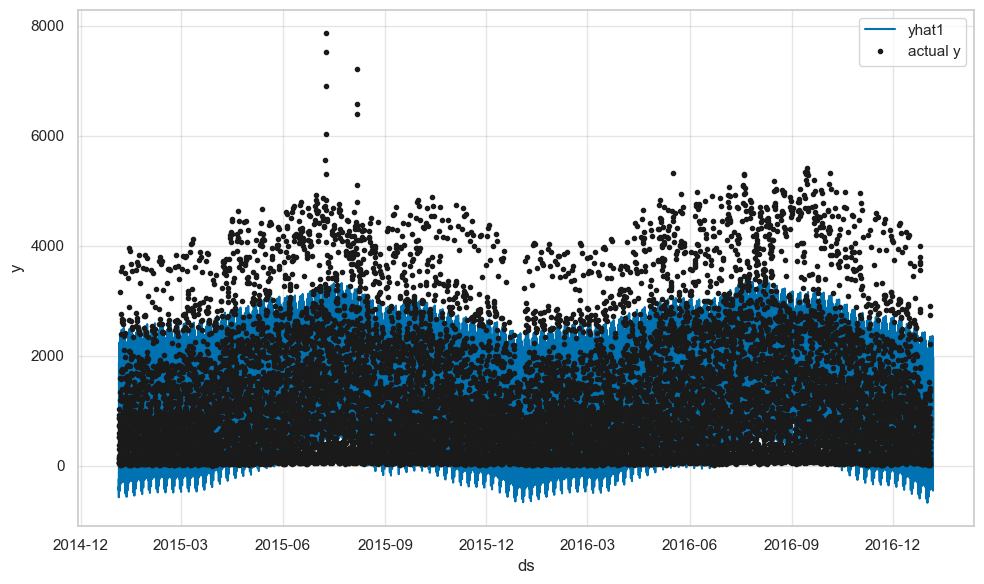

In [ ]:
plot_forecast(model, df_test, periods=60)

In [ ]:
preds = list(df)[1:]

In [ ]:
def get_global_df(data, preds):
    df_global = pd.DataFrame()
    for pred in preds:
        aux = df[['ds', pred]].copy(deep = True) #select column associated with region
        df.reset_index(drop=True, inplace=True)
        # aux = aux.iloc[:26301, :].copy(deep = True) #selects data up to 26301 row (2004 to 2007 time stamps)
        aux = aux.rename(columns = {pred: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
        aux['ID'] = pred
        df_global = pd.concat((df_global, aux))
    
    return df_global

In [ ]:
df_test = df.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]

In [ ]:
future = model.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = model.predict(future)
fig = model.plot(forecast[forecast['ID'] ==  'NORTH'])

In [ ]:
def plot_forecast(model, data, pred_names, historic_pred=True):
    
    future = model.make_future_dataframe(data, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    def plot_subplots(model, forecast, pred_names):

        pred_len = len(pred_names)
        num_cols = int(np.sqrt(pred_len))
        num_rows = int(pred_len / num_cols)

        fig, axs = plt.subplots(nrows = num_rows + (1 if pred_len % num_cols != 0 else 0), ncols = num_cols, figsize = (10 * num_rows, 10 * num_cols))
        fig.suptitle('Subplots for Global Model Using Local Normalization', fontsize=20, y=0.95)

        for pred, ax in zip(pred_names, axs.ravel()):
            model.plot(forecast[forecast['ID'] == pred], xlabel='Date', ylabel='Bike Share Count', ax=ax)
            ax.set_title(pred)

    plot_subplots(model, forecast, pred_names)

In [ ]:
df_train = df.loc[(df['timestamp'] >= '2015-01-04') & (df['timestamp'] <= '2016-09-30')]
df_test = df.loc[(df['timestamp'] >= '2016-10-01') & (df['timestamp'] <= '2017-01-03')]

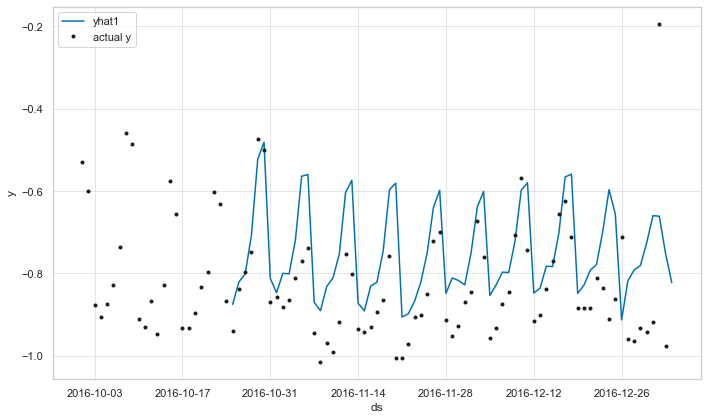

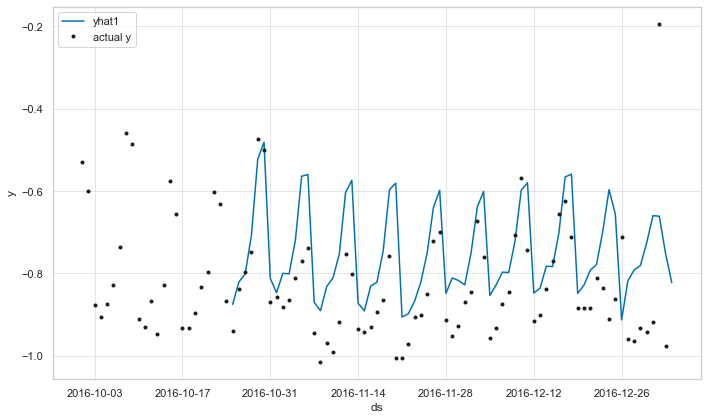

In [ ]:
future = model.make_future_dataframe(test, n_historic_predictions=True)
forecast = model.predict(future)
model.plot(forecast, df_name='cnt')